It's kernel investigate problems of the use CNN for line fault detection.

In [1]:
import os
import gc
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from numba import jit, int32

In [2]:
INIT_DIR = 'E:/kaggle/3AC'
SIZE = 256

In [3]:
os.getcwd()

'C:\\Users\\aobang'

In [4]:
os.listdir(INIT_DIR)

['metadata_test.csv',
 'metadata_train.csv',
 'sample_submission.csv',
 'test.parquet',
 'train.parquet']

<center>  **Preprocessing**

In [5]:
meta = pd.read_csv(os.path.join(INIT_DIR, 'metadata_train.csv'))

In [6]:
train = pq.read_pandas(os.path.join(INIT_DIR, 'train.parquet')).to_pandas()

In [7]:
meta.describe()

,signal_id,id_measurement,phase,target
count,8712.000000,8712.000000,8712.000000,8712.000000
mean,4355.500000,1451.500000,1.000000,0.060262
std,2515.082106,838.360658,0.816543,0.237985
min,0.000000,0.000000,0.000000,0.000000
25%,2177.750000,725.750000,0.000000,0.000000
50%,4355.500000,1451.500000,1.000000,0.000000
75%,6533.250000,2177.250000,2.000000,0.000000
max,8711.000000,2903.000000,2.000000,1.000000


In [8]:
meta.corr()

,signal_id,id_measurement,phase,target
signal_id,1.000000,1.000000,0.000325,-0.023992
id_measurement,1.000000,1.000000,0.000000,-0.023993
phase,0.000325,0.000000,1.000000,0.001772
target,-0.023992,-0.023993,0.001772,1.000000


Data contain 3 phase signal for each mesuarment. From table above we can see that target independant from phase and id_mesurment.

In [9]:
positive_mid = np.unique(meta.loc[meta.target == 1, 'id_measurement'].values)
negative_mid = np.unique(meta.loc[meta.target == 0, 'id_measurement'].values)

In [10]:
pid = meta.loc[meta.id_measurement == positive_mid[0], 'signal_id']
nid = meta.loc[meta.id_measurement == negative_mid[0], 'signal_id']

In [11]:
positive_sample = train.iloc[:, pid]
negative_sample = train.iloc[:, nid]

Signal with phase, for my mind, will not be useful for CNN or RNN model.  For this case I'm apply filter like HPF for signal flatten. And thus I can more easier extract specific noise and anomaly feature.  

!!! Numba is very useful tool for situation like this !!!

In [12]:
@jit('float32(float32[:,:], int32, int32)')
def flatiron(x, alpha=100., beta=1):
    new_x = np.zeros_like(x)
    zero = x[0]
    for i in range(1, len(x)):
        zero = zero*(alpha-beta)/alpha + beta*x[i]/alpha
        new_x[i] =  x[i] - zero
    return new_x

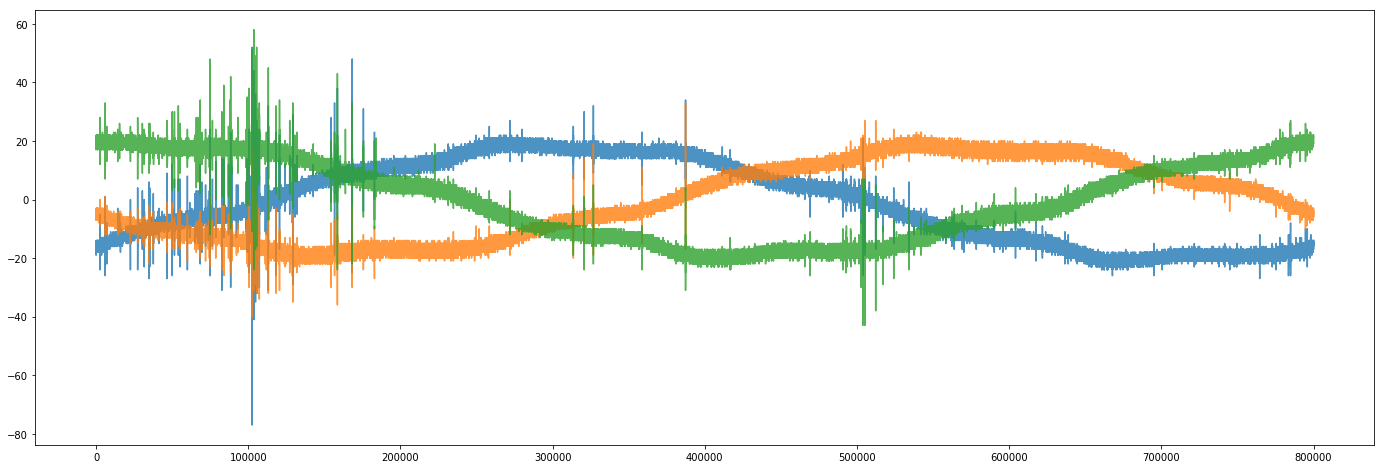

In [13]:
plt.figure(figsize=(24, 8))
plt.plot(positive_sample, alpha=0.8);

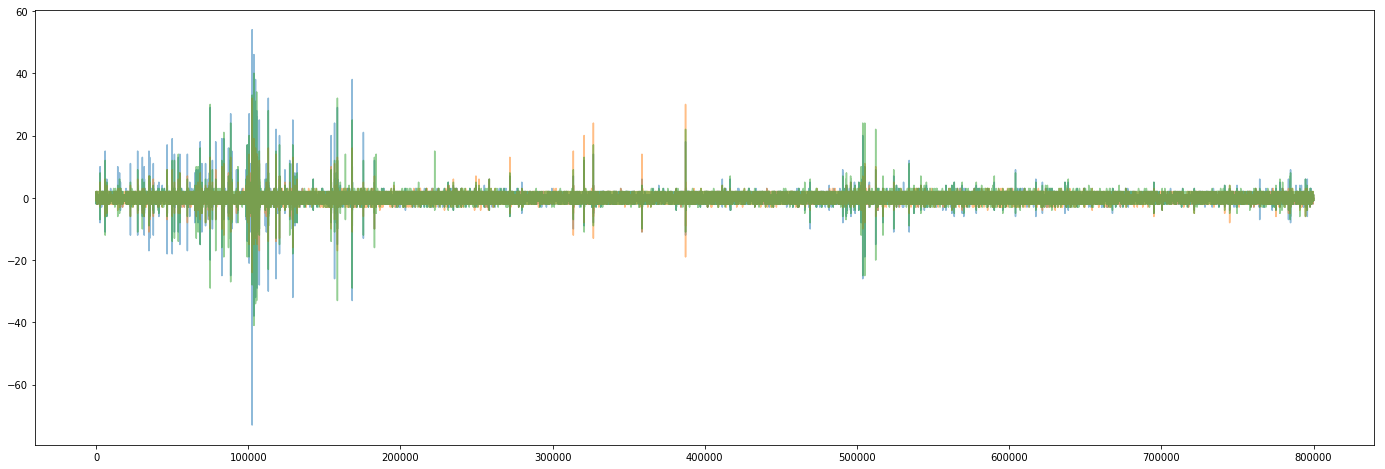

In [14]:
x_filt = flatiron(positive_sample.values)
plt.figure(figsize=(24, 8))
plt.plot(x_filt, alpha=0.5);

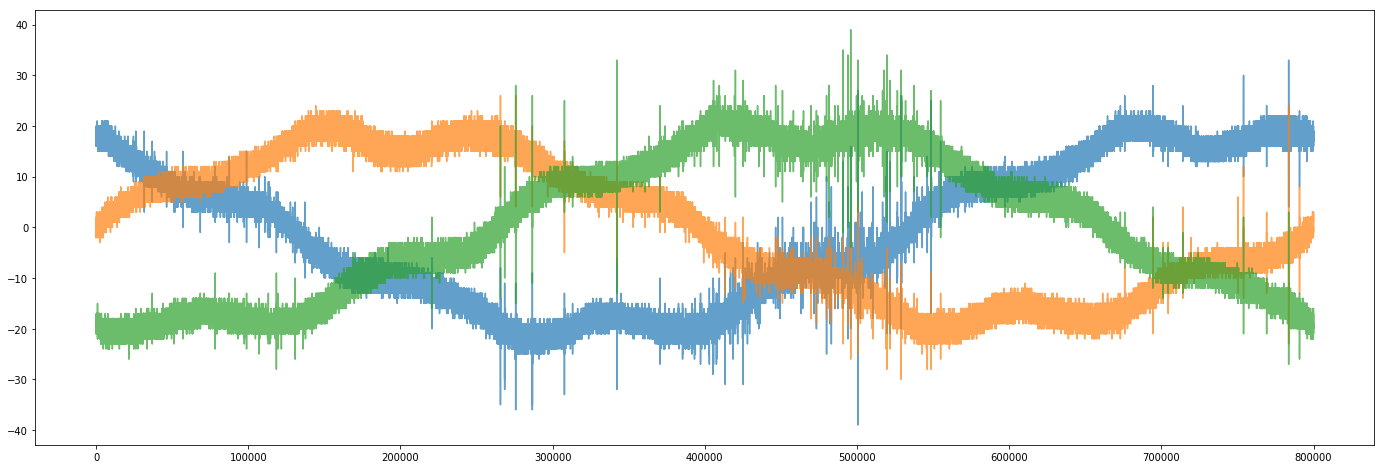

In [15]:
plt.figure(figsize=(24, 8))
plt.plot(negative_sample, alpha=0.7);

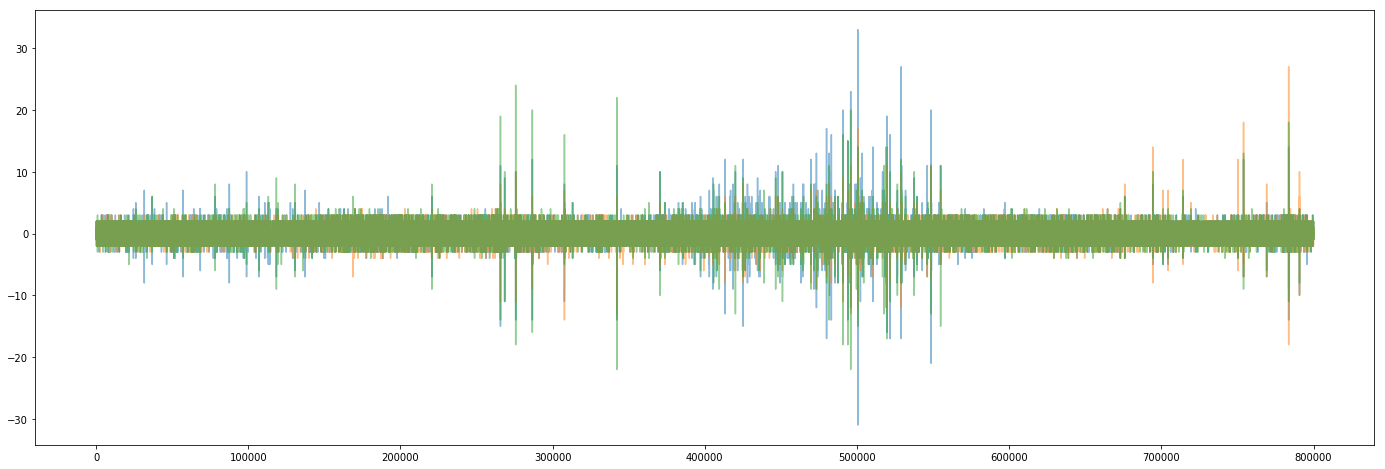

In [16]:
x_filt = flatiron(negative_sample.values)
plt.figure(figsize=(24, 8))
plt.plot(x_filt, alpha=0.5);

In [17]:
for i in tqdm(range(len(meta))):
    train.iloc[:, i] = flatiron(train.iloc[:, i].values)

In [18]:
@jit('float32(float32[:,:], int32)')
def feature_extractor(x, n_part=1000):
    lenght = len(x)
    pool = np.int32(np.ceil(lenght/n_part))
    output = np.zeros((n_part, 3))
    for j, i in enumerate(range(0,lenght, pool)):
        if i+pool < lenght:
            k = x[i:i+pool]
        else:
            k = x[i:]
        output[j] = np.max(k, axis=0) - np.min(k, axis=0)
    return output

In [19]:
x_train = []
y_train = []
for i in tqdm(meta.id_measurement):
    try:
        idx = meta.loc[meta.id_measurement==i, 'signal_id'].values.tolist()
        x_train.append(abs(feature_extractor(train.iloc[:, idx].values, n_part=SIZE)))
        y_train.append(meta.loc[meta.id_measurement==i, 'target'].values)
    except:
        pass

In [20]:
del train, meta;gc.collect()

16513

In [21]:
np.unique(y_train)

array([0, 1], dtype=int64)

In [22]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [23]:
print(np.shape(x_train), np.shape(y_train))

(8712, 256, 3) (8712, 3)


In cell below we can see, that for one measurement various number channels can be fault.

In [24]:
csum = np.sum(y_train, axis=-1)
np.unique(csum)

array([0, 1, 2, 3], dtype=int64)

In [25]:
pos_index = np.where(csum>0)[0]
neg_index = np.where(csum==0)[0]

At the plots below we can see features(amplitude), which extracted from signal, for positive and negative case.

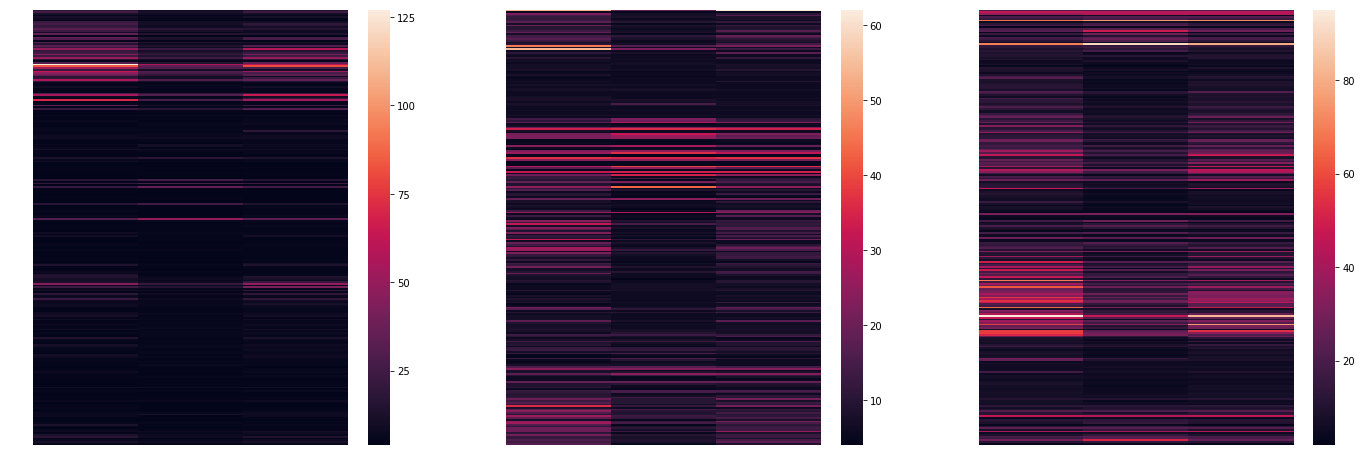

In [26]:
figure, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,8))
sns.heatmap(x_train[pos_index[0], :, :], ax=ax1)
sns.heatmap(x_train[pos_index[10], :, :], ax=ax2)
sns.heatmap(x_train[pos_index[20], :, :], ax=ax3)
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off();

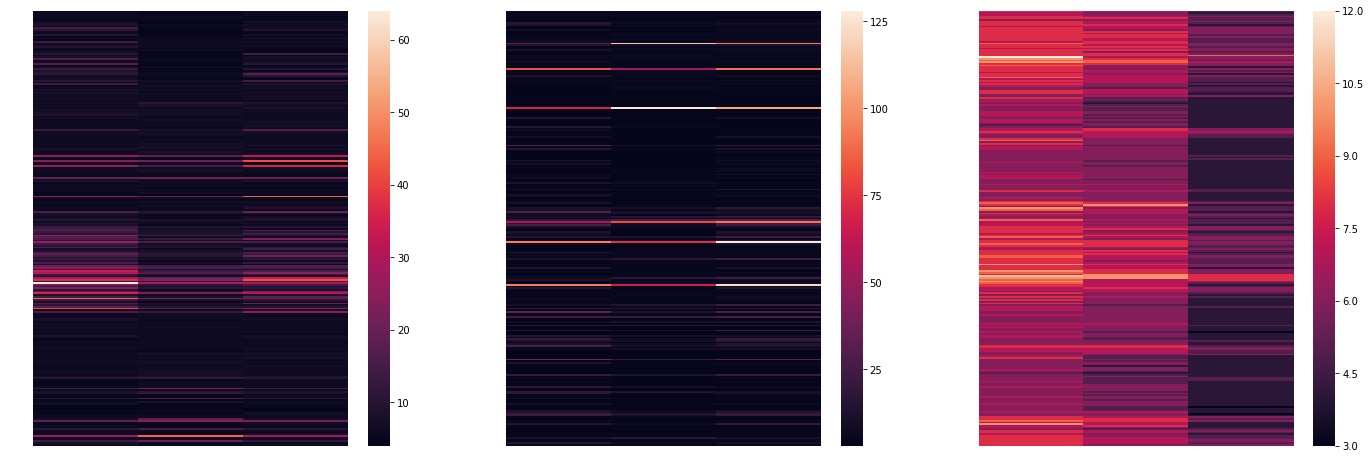

In [27]:
figure, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,8))
sns.heatmap(x_train[neg_index[0], :, :], ax=ax1)
sns.heatmap(x_train[neg_index[10], :, :], ax=ax2)
sns.heatmap(x_train[neg_index[20], :, :], ax=ax3)
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off();

<center> **CNN**

In [28]:
from keras.layers import *
from keras import Model
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [29]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale

In [30]:
import tensorflow as tf

class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     # shape=self.kernel_size,
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        # final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  # shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))  # shape = [None, input_num_capsule, num_capsule]
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(tf.keras.backend.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = tf.keras.backend.batch_dot(outputs, u_hat_vecs, [2, 3])
        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [31]:
def matthews_corr_coeff(y_true, y_pred):
    y_pos_pred = K.round(K.clip(y_pred, 0, 1))
    y_pos_true = K.round(K.clip(y_true, 0, 1))
    
    y_neg_pred = 1 - y_pos_pred
    y_neg_true = 1 - y_pos_true

    tp = K.sum(y_pos_true * y_pos_pred)
    tn = K.sum(y_neg_true * y_neg_pred)
    fp = K.sum(y_neg_true * y_pos_pred)
    fn = K.sum(y_pos_true * y_neg_pred)
    return (tp * tn - fp * fn) / (K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) + K.epsilon())

For time series very useful use dilation and  for CNN useful apply in architecture residual connection.

In [32]:
def get_model(inp_shape=(SIZE, 3)):
    inp = Input(inp_shape)
    x = BatchNormalization()(inp)
    # 256
    x = Conv1D(32, kernel_size=3, dilation_rate=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(32, kernel_size=3, dilation_rate=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    
    #  128
    x = Conv1D(64, kernel_size=3, dilation_rate=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x_prev = x
    x = Conv1D(64, kernel_size=3, dilation_rate=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Add()([x, x_prev])
    x_prev = x
    
    x = Conv1D(64, kernel_size=3, dilation_rate=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Add()([x, x_prev])
    x_prev = x
    
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    
    # 64
    x = Conv1D(128, kernel_size=3, dilation_rate=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x_prev = x
    x = Conv1D(128, kernel_size=3, dilation_rate=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Add()([x, x_prev])
    x_prev = x
    
    x = Conv1D(128, kernel_size=3, dilation_rate=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Add()([x, x_prev])
    x_prev = x
    
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    
    #  32
    x = Conv1D(128, kernel_size=3, dilation_rate=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x_prev = x
    x = Conv1D(128, kernel_size=3, dilation_rate=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Add()([x, x_prev])
    x_prev = x
    
    x = Conv1D(128, kernel_size=3, dilation_rate=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Add()([x, x_prev])
    x_prev = x
    
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    
    #  16
    x = Conv1D(256, kernel_size=3, dilation_rate=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x_prev = x
    x = Conv1D(256, kernel_size=3, dilation_rate=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Add()([x, x_prev])
    x_prev = x
    
    x = Conv1D(256, kernel_size=3, dilation_rate=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Add()([x, x_prev])
    x_prev = x
    
    x = Capsule(num_capsule = 15, dim_capsule=15)(x)
    
    x = Flatten()(x)
    
    x = Dropout(0.55)(x)
    
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    
    out = Dense(3, activation='sigmoid')(x)
    return Model(inp, out)

In [33]:
mcp = ModelCheckpoint('model.h5',monitor='val_matthews_corr_coeff', mode='max')

In [34]:
from sklearn.model_selection import train_test_split, KFold

In [35]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, shuffle=True, train_size=0.85, random_state=28, stratify=csum)

C:\Users\aobang\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [36]:
x_concat = []
y_concat = []
for x_item, y_item in tqdm(zip(x_tr, y_tr)):
    first = x_item[:, 0]
    second = x_item[:, 1]
    third = x_item[:, 2]
    
    x_concat.append(np.stack([first, second, third], axis=-1))
    y_concat.append(np.stack([y_item[0], y_item[1], y_item[2]], axis=-1))
    
    x_concat.append(np.stack([second, first, third], axis=-1))
    y_concat.append(np.stack([y_item[1], y_item[0], y_item[2]], axis=-1))
    
    x_concat.append(np.stack([third, second, first], axis=-1))
    y_concat.append(np.stack([y_item[2], y_item[1], y_item[0]], axis=-1))
    
    x_concat.append(np.stack([first, third, second], axis=-1))
    y_concat.append(np.stack([y_item[0], y_item[2], y_item[1]], axis=-1))
    
x_tr = np.array(x_concat)
y_tr = np.array(y_concat)

In [37]:
model = get_model()
print(model.summary())
model.compile(optimizer=Nadam(1e-3, schedule_decay=1e-5),loss='binary_crossentropy', metrics=['accuracy', matthews_corr_coeff])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 3)       0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 3)       12          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 256, 32)      320         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256, 32)      128         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [38]:
model.fit(x=x_tr, y=y_tr, batch_size=64,epochs=15, callbacks=[mcp], validation_data=[x_val, y_val])
model.load_weights('model.h5')
best_thr = 0.01
best_metric = 0
y_val = y_val.flatten()
for i in tqdm(np.linspace(0.01, 0.9999, 100)):
    y_pred = np.int32(model.predict(x_val) > i).flatten()
    m = matthews_corrcoef(y_val, y_pred)
    if m > best_metric:
        best_thr = i
        best_metric= m
print('Best threshold: ',best_thr, ' ; Best metric: ',best_metric)

Train on 29620 samples, validate on 1307 samples
Epoch 1/15
11456/29620 [==========>...................] - ETA: 1:06:08 - loss: 0.7731 - acc: 0.4948 - matthews_corr_coeff: -0.056 - ETA: 33:14 - loss: 0.8014 - acc: 0.4844 - matthews_corr_coeff: -0.0289  - ETA: 16:43 - loss: 0.7909 - acc: 0.4922 - matthews_corr_coeff: -0.029 - ETA: 13:26 - loss: 0.7780 - acc: 0.4938 - matthews_corr_coeff: -0.004 - ETA: 9:39 - loss: 0.7589 - acc: 0.5074 - matthews_corr_coeff: 0.0189  - ETA: 7:33 - loss: 0.7515 - acc: 0.5133 - matthews_corr_coeff: 0.027 - ETA: 6:49 - loss: 0.7476 - acc: 0.5182 - matthews_corr_coeff: 0.027 - ETA: 5:42 - loss: 0.7374 - acc: 0.5291 - matthews_corr_coeff: 0.038 - ETA: 5:17 - loss: 0.7335 - acc: 0.5341 - matthews_corr_coeff: 0.044 - ETA: 4:56 - loss: 0.7290 - acc: 0.5394 - matthews_corr_coeff: 0.046 - ETA: 4:20 - loss: 0.7193 - acc: 0.5534 - matthews_corr_coeff: 0.066 - ETA: 4:06 - loss: 0.7145 - acc: 0.5591 - matthews_corr_coeff: 0.072 - ETA: 3:41 - loss: 0.7041 - acc: 0.5726 

11840/29620 [==========>...................] - ETA: 24s - loss: 0.0837 - acc: 0.9740 - matthews_corr_coeff: 0.69 - ETA: 20s - loss: 0.1030 - acc: 0.9688 - matthews_corr_coeff: 0.59 - ETA: 22s - loss: 0.1176 - acc: 0.9557 - matthews_corr_coeff: 0.56 - ETA: 21s - loss: 0.1232 - acc: 0.9557 - matthews_corr_coeff: 0.56 - ETA: 21s - loss: 0.1239 - acc: 0.9576 - matthews_corr_coeff: 0.57 - ETA: 20s - loss: 0.1317 - acc: 0.9497 - matthews_corr_coeff: 0.49 - ETA: 21s - loss: 0.1352 - acc: 0.9490 - matthews_corr_coeff: 0.49 - ETA: 20s - loss: 0.1315 - acc: 0.9475 - matthews_corr_coeff: 0.48 - ETA: 20s - loss: 0.1268 - acc: 0.9475 - matthews_corr_coeff: 0.45 - ETA: 20s - loss: 0.1248 - acc: 0.9489 - matthews_corr_coeff: 0.46 - ETA: 20s - loss: 0.1218 - acc: 0.9504 - matthews_corr_coeff: 0.47 - ETA: 20s - loss: 0.1271 - acc: 0.9476 - matthews_corr_coeff: 0.42 - ETA: 20s - loss: 0.1260 - acc: 0.9471 - matthews_corr_coeff: 0.43 - ETA: 20s - loss: 0.1212 - acc: 0.9496 - matthews_corr_coeff: 0.45 - E

29620/29620 [==============================] - ETA: 4s - loss: 0.1189 - acc: 0.9516 - matthews_corr_coeff: 0.516 - ETA: 4s - loss: 0.1188 - acc: 0.9517 - matthews_corr_coeff: 0.516 - ETA: 3s - loss: 0.1186 - acc: 0.9518 - matthews_corr_coeff: 0.517 - ETA: 3s - loss: 0.1185 - acc: 0.9518 - matthews_corr_coeff: 0.517 - ETA: 3s - loss: 0.1183 - acc: 0.9518 - matthews_corr_coeff: 0.517 - ETA: 3s - loss: 0.1181 - acc: 0.9518 - matthews_corr_coeff: 0.517 - ETA: 3s - loss: 0.1181 - acc: 0.9518 - matthews_corr_coeff: 0.516 - ETA: 3s - loss: 0.1183 - acc: 0.9518 - matthews_corr_coeff: 0.516 - ETA: 3s - loss: 0.1182 - acc: 0.9518 - matthews_corr_coeff: 0.516 - ETA: 3s - loss: 0.1184 - acc: 0.9517 - matthews_corr_coeff: 0.517 - ETA: 3s - loss: 0.1183 - acc: 0.9518 - matthews_corr_coeff: 0.517 - ETA: 3s - loss: 0.1182 - acc: 0.9518 - matthews_corr_coeff: 0.518 - ETA: 3s - loss: 0.1184 - acc: 0.9517 - matthews_corr_coeff: 0.518 - ETA: 3s - loss: 0.1187 - acc: 0.9517 - matthews_corr_coeff: 0.519 - E

11584/29620 [==========>...................] - ETA: 25s - loss: 0.0820 - acc: 0.9427 - matthews_corr_coeff: 0.54 - ETA: 24s - loss: 0.0876 - acc: 0.9479 - matthews_corr_coeff: 0.62 - ETA: 21s - loss: 0.0862 - acc: 0.9596 - matthews_corr_coeff: 0.71 - ETA: 22s - loss: 0.0806 - acc: 0.9646 - matthews_corr_coeff: 0.74 - ETA: 20s - loss: 0.0888 - acc: 0.9613 - matthews_corr_coeff: 0.71 - ETA: 21s - loss: 0.1042 - acc: 0.9570 - matthews_corr_coeff: 0.70 - ETA: 20s - loss: 0.1066 - acc: 0.9583 - matthews_corr_coeff: 0.68 - ETA: 21s - loss: 0.1162 - acc: 0.9555 - matthews_corr_coeff: 0.64 - ETA: 20s - loss: 0.1154 - acc: 0.9519 - matthews_corr_coeff: 0.58 - ETA: 21s - loss: 0.1246 - acc: 0.9490 - matthews_corr_coeff: 0.56 - ETA: 21s - loss: 0.1233 - acc: 0.9493 - matthews_corr_coeff: 0.56 - ETA: 21s - loss: 0.1252 - acc: 0.9489 - matthews_corr_coeff: 0.56 - ETA: 21s - loss: 0.1248 - acc: 0.9479 - matthews_corr_coeff: 0.56 - ETA: 21s - loss: 0.1263 - acc: 0.9471 - matthews_corr_coeff: 0.55 - E

29620/29620 [==============================] - ETA: 4s - loss: 0.1087 - acc: 0.9533 - matthews_corr_coeff: 0.542 - ETA: 4s - loss: 0.1088 - acc: 0.9533 - matthews_corr_coeff: 0.543 - ETA: 4s - loss: 0.1089 - acc: 0.9532 - matthews_corr_coeff: 0.543 - ETA: 4s - loss: 0.1091 - acc: 0.9531 - matthews_corr_coeff: 0.543 - ETA: 4s - loss: 0.1088 - acc: 0.9533 - matthews_corr_coeff: 0.544 - ETA: 4s - loss: 0.1089 - acc: 0.9532 - matthews_corr_coeff: 0.544 - ETA: 3s - loss: 0.1089 - acc: 0.9531 - matthews_corr_coeff: 0.544 - ETA: 3s - loss: 0.1088 - acc: 0.9531 - matthews_corr_coeff: 0.543 - ETA: 3s - loss: 0.1086 - acc: 0.9532 - matthews_corr_coeff: 0.544 - ETA: 3s - loss: 0.1086 - acc: 0.9532 - matthews_corr_coeff: 0.544 - ETA: 3s - loss: 0.1086 - acc: 0.9532 - matthews_corr_coeff: 0.545 - ETA: 3s - loss: 0.1083 - acc: 0.9534 - matthews_corr_coeff: 0.546 - ETA: 3s - loss: 0.1084 - acc: 0.9533 - matthews_corr_coeff: 0.545 - ETA: 3s - loss: 0.1083 - acc: 0.9533 - matthews_corr_coeff: 0.544 - E

11968/29620 [===========>..................] - ETA: 22s - loss: 0.0473 - acc: 0.9844 - matthews_corr_coeff: 0.85 - ETA: 20s - loss: 0.0532 - acc: 0.9757 - matthews_corr_coeff: 0.74 - ETA: 20s - loss: 0.0526 - acc: 0.9802 - matthews_corr_coeff: 0.80 - ETA: 20s - loss: 0.0638 - acc: 0.9731 - matthews_corr_coeff: 0.67 - ETA: 20s - loss: 0.0703 - acc: 0.9688 - matthews_corr_coeff: 0.65 - ETA: 20s - loss: 0.0793 - acc: 0.9647 - matthews_corr_coeff: 0.63 - ETA: 20s - loss: 0.0766 - acc: 0.9659 - matthews_corr_coeff: 0.66 - ETA: 20s - loss: 0.0739 - acc: 0.9674 - matthews_corr_coeff: 0.68 - ETA: 20s - loss: 0.0749 - acc: 0.9669 - matthews_corr_coeff: 0.69 - ETA: 20s - loss: 0.0792 - acc: 0.9648 - matthews_corr_coeff: 0.69 - ETA: 20s - loss: 0.0775 - acc: 0.9666 - matthews_corr_coeff: 0.70 - ETA: 19s - loss: 0.0765 - acc: 0.9660 - matthews_corr_coeff: 0.70 - ETA: 20s - loss: 0.0761 - acc: 0.9664 - matthews_corr_coeff: 0.70 - ETA: 19s - loss: 0.0742 - acc: 0.9688 - matthews_corr_coeff: 0.72 - E

29620/29620 [==============================] - ETA: 3s - loss: 0.0915 - acc: 0.9628 - matthews_corr_coeff: 0.663 - ETA: 3s - loss: 0.0914 - acc: 0.9628 - matthews_corr_coeff: 0.663 - ETA: 3s - loss: 0.0914 - acc: 0.9628 - matthews_corr_coeff: 0.663 - ETA: 3s - loss: 0.0914 - acc: 0.9628 - matthews_corr_coeff: 0.663 - ETA: 3s - loss: 0.0914 - acc: 0.9628 - matthews_corr_coeff: 0.663 - ETA: 3s - loss: 0.0913 - acc: 0.9628 - matthews_corr_coeff: 0.663 - ETA: 3s - loss: 0.0911 - acc: 0.9629 - matthews_corr_coeff: 0.664 - ETA: 3s - loss: 0.0912 - acc: 0.9629 - matthews_corr_coeff: 0.663 - ETA: 3s - loss: 0.0914 - acc: 0.9628 - matthews_corr_coeff: 0.662 - ETA: 3s - loss: 0.0914 - acc: 0.9627 - matthews_corr_coeff: 0.661 - ETA: 3s - loss: 0.0917 - acc: 0.9625 - matthews_corr_coeff: 0.660 - ETA: 3s - loss: 0.0917 - acc: 0.9625 - matthews_corr_coeff: 0.658 - ETA: 3s - loss: 0.0917 - acc: 0.9626 - matthews_corr_coeff: 0.658 - ETA: 3s - loss: 0.0916 - acc: 0.9626 - matthews_corr_coeff: 0.658 - E

11840/29620 [==========>...................] - ETA: 26s - loss: 0.1134 - acc: 0.9844 - matthews_corr_coeff: 0.91 - ETA: 20s - loss: 0.0959 - acc: 0.9688 - matthews_corr_coeff: 0.82 - ETA: 22s - loss: 0.0940 - acc: 0.9701 - matthews_corr_coeff: 0.83 - ETA: 20s - loss: 0.0830 - acc: 0.9740 - matthews_corr_coeff: 0.81 - ETA: 21s - loss: 0.1014 - acc: 0.9673 - matthews_corr_coeff: 0.76 - ETA: 21s - loss: 0.0930 - acc: 0.9659 - matthews_corr_coeff: 0.69 - ETA: 20s - loss: 0.0812 - acc: 0.9706 - matthews_corr_coeff: 0.73 - ETA: 21s - loss: 0.0871 - acc: 0.9679 - matthews_corr_coeff: 0.70 - ETA: 20s - loss: 0.0881 - acc: 0.9658 - matthews_corr_coeff: 0.71 - ETA: 20s - loss: 0.0898 - acc: 0.9639 - matthews_corr_coeff: 0.71 - ETA: 20s - loss: 0.0936 - acc: 0.9629 - matthews_corr_coeff: 0.71 - ETA: 20s - loss: 0.0958 - acc: 0.9608 - matthews_corr_coeff: 0.70 - ETA: 20s - loss: 0.0965 - acc: 0.9599 - matthews_corr_coeff: 0.70 - ETA: 20s - loss: 0.0980 - acc: 0.9583 - matthews_corr_coeff: 0.69 - E

29620/29620 [==============================] - ETA: 4s - loss: 0.0793 - acc: 0.9677 - matthews_corr_coeff: 0.710 - ETA: 4s - loss: 0.0792 - acc: 0.9678 - matthews_corr_coeff: 0.710 - ETA: 3s - loss: 0.0790 - acc: 0.9679 - matthews_corr_coeff: 0.711 - ETA: 3s - loss: 0.0788 - acc: 0.9680 - matthews_corr_coeff: 0.712 - ETA: 3s - loss: 0.0789 - acc: 0.9680 - matthews_corr_coeff: 0.712 - ETA: 3s - loss: 0.0788 - acc: 0.9681 - matthews_corr_coeff: 0.713 - ETA: 3s - loss: 0.0786 - acc: 0.9682 - matthews_corr_coeff: 0.714 - ETA: 3s - loss: 0.0787 - acc: 0.9682 - matthews_corr_coeff: 0.713 - ETA: 3s - loss: 0.0788 - acc: 0.9681 - matthews_corr_coeff: 0.713 - ETA: 3s - loss: 0.0788 - acc: 0.9681 - matthews_corr_coeff: 0.713 - ETA: 3s - loss: 0.0786 - acc: 0.9681 - matthews_corr_coeff: 0.713 - ETA: 3s - loss: 0.0790 - acc: 0.9681 - matthews_corr_coeff: 0.714 - ETA: 3s - loss: 0.0789 - acc: 0.9682 - matthews_corr_coeff: 0.714 - ETA: 3s - loss: 0.0788 - acc: 0.9683 - matthews_corr_coeff: 0.715 - E

11072/29620 [==========>...................] - ETA: 28s - loss: 0.0698 - acc: 0.9844 - matthews_corr_coeff: 0.85 - ETA: 22s - loss: 0.0884 - acc: 0.9688 - matthews_corr_coeff: 0.75 - ETA: 22s - loss: 0.0783 - acc: 0.9714 - matthews_corr_coeff: 0.77 - ETA: 23s - loss: 0.0947 - acc: 0.9677 - matthews_corr_coeff: 0.76 - ETA: 23s - loss: 0.0906 - acc: 0.9696 - matthews_corr_coeff: 0.77 - ETA: 23s - loss: 0.0907 - acc: 0.9695 - matthews_corr_coeff: 0.78 - ETA: 22s - loss: 0.0841 - acc: 0.9711 - matthews_corr_coeff: 0.79 - ETA: 22s - loss: 0.0791 - acc: 0.9734 - matthews_corr_coeff: 0.81 - ETA: 22s - loss: 0.0749 - acc: 0.9759 - matthews_corr_coeff: 0.82 - ETA: 22s - loss: 0.0713 - acc: 0.9779 - matthews_corr_coeff: 0.84 - ETA: 22s - loss: 0.0714 - acc: 0.9788 - matthews_corr_coeff: 0.84 - ETA: 22s - loss: 0.0768 - acc: 0.9760 - matthews_corr_coeff: 0.82 - ETA: 22s - loss: 0.0766 - acc: 0.9759 - matthews_corr_coeff: 0.82 - ETA: 22s - loss: 0.0777 - acc: 0.9746 - matthews_corr_coeff: 0.82 - E

29620/29620 [==============================] - ETA: 4s - loss: 0.0642 - acc: 0.9744 - matthews_corr_coeff: 0.775 - ETA: 4s - loss: 0.0641 - acc: 0.9745 - matthews_corr_coeff: 0.776 - ETA: 4s - loss: 0.0640 - acc: 0.9745 - matthews_corr_coeff: 0.775 - ETA: 4s - loss: 0.0639 - acc: 0.9746 - matthews_corr_coeff: 0.776 - ETA: 4s - loss: 0.0640 - acc: 0.9745 - matthews_corr_coeff: 0.775 - ETA: 4s - loss: 0.0638 - acc: 0.9746 - matthews_corr_coeff: 0.776 - ETA: 4s - loss: 0.0637 - acc: 0.9747 - matthews_corr_coeff: 0.777 - ETA: 4s - loss: 0.0636 - acc: 0.9747 - matthews_corr_coeff: 0.776 - ETA: 4s - loss: 0.0636 - acc: 0.9746 - matthews_corr_coeff: 0.776 - ETA: 4s - loss: 0.0637 - acc: 0.9746 - matthews_corr_coeff: 0.775 - ETA: 4s - loss: 0.0636 - acc: 0.9746 - matthews_corr_coeff: 0.775 - ETA: 4s - loss: 0.0636 - acc: 0.9747 - matthews_corr_coeff: 0.776 - ETA: 3s - loss: 0.0636 - acc: 0.9747 - matthews_corr_coeff: 0.776 - ETA: 3s - loss: 0.0635 - acc: 0.9747 - matthews_corr_coeff: 0.776 - E

11520/29620 [==========>...................] - ETA: 25s - loss: 0.0514 - acc: 0.9583 - matthews_corr_coeff: 0.19 - ETA: 20s - loss: 0.0583 - acc: 0.9635 - matthews_corr_coeff: 0.58 - ETA: 22s - loss: 0.0486 - acc: 0.9727 - matthews_corr_coeff: 0.68 - ETA: 20s - loss: 0.0554 - acc: 0.9644 - matthews_corr_coeff: 0.58 - ETA: 21s - loss: 0.0534 - acc: 0.9688 - matthews_corr_coeff: 0.62 - ETA: 21s - loss: 0.0508 - acc: 0.9722 - matthews_corr_coeff: 0.67 - ETA: 21s - loss: 0.0523 - acc: 0.9714 - matthews_corr_coeff: 0.65 - ETA: 20s - loss: 0.0512 - acc: 0.9731 - matthews_corr_coeff: 0.69 - ETA: 20s - loss: 0.0525 - acc: 0.9736 - matthews_corr_coeff: 0.71 - ETA: 20s - loss: 0.0481 - acc: 0.9767 - matthews_corr_coeff: 0.74 - ETA: 20s - loss: 0.0462 - acc: 0.9779 - matthews_corr_coeff: 0.75 - ETA: 20s - loss: 0.0456 - acc: 0.9780 - matthews_corr_coeff: 0.77 - ETA: 20s - loss: 0.0458 - acc: 0.9786 - matthews_corr_coeff: 0.77 - ETA: 20s - loss: 0.0461 - acc: 0.9787 - matthews_corr_coeff: 0.77 - E

29620/29620 [==============================] - ETA: 4s - loss: 0.0649 - acc: 0.9732 - matthews_corr_coeff: 0.756 - ETA: 4s - loss: 0.0649 - acc: 0.9733 - matthews_corr_coeff: 0.757 - ETA: 4s - loss: 0.0647 - acc: 0.9734 - matthews_corr_coeff: 0.757 - ETA: 4s - loss: 0.0647 - acc: 0.9734 - matthews_corr_coeff: 0.758 - ETA: 4s - loss: 0.0647 - acc: 0.9734 - matthews_corr_coeff: 0.758 - ETA: 3s - loss: 0.0646 - acc: 0.9734 - matthews_corr_coeff: 0.757 - ETA: 3s - loss: 0.0646 - acc: 0.9734 - matthews_corr_coeff: 0.758 - ETA: 3s - loss: 0.0646 - acc: 0.9734 - matthews_corr_coeff: 0.758 - ETA: 3s - loss: 0.0645 - acc: 0.9734 - matthews_corr_coeff: 0.758 - ETA: 3s - loss: 0.0646 - acc: 0.9734 - matthews_corr_coeff: 0.758 - ETA: 3s - loss: 0.0645 - acc: 0.9734 - matthews_corr_coeff: 0.758 - ETA: 3s - loss: 0.0646 - acc: 0.9734 - matthews_corr_coeff: 0.758 - ETA: 3s - loss: 0.0649 - acc: 0.9733 - matthews_corr_coeff: 0.758 - ETA: 3s - loss: 0.0648 - acc: 0.9733 - matthews_corr_coeff: 0.758 - E

11776/29620 [==========>...................] - ETA: 25s - loss: 0.0151 - acc: 0.9948 - matthews_corr_coeff: 0.94 - ETA: 20s - loss: 0.0275 - acc: 0.9878 - matthews_corr_coeff: 0.90 - ETA: 21s - loss: 0.0327 - acc: 0.9831 - matthews_corr_coeff: 0.89 - ETA: 20s - loss: 0.0334 - acc: 0.9844 - matthews_corr_coeff: 0.89 - ETA: 21s - loss: 0.0313 - acc: 0.9844 - matthews_corr_coeff: 0.86 - ETA: 20s - loss: 0.0301 - acc: 0.9850 - matthews_corr_coeff: 0.87 - ETA: 21s - loss: 0.0287 - acc: 0.9859 - matthews_corr_coeff: 0.88 - ETA: 20s - loss: 0.0302 - acc: 0.9870 - matthews_corr_coeff: 0.89 - ETA: 20s - loss: 0.0322 - acc: 0.9866 - matthews_corr_coeff: 0.88 - ETA: 20s - loss: 0.0352 - acc: 0.9854 - matthews_corr_coeff: 0.87 - ETA: 20s - loss: 0.0351 - acc: 0.9862 - matthews_corr_coeff: 0.87 - ETA: 20s - loss: 0.0341 - acc: 0.9870 - matthews_corr_coeff: 0.88 - ETA: 20s - loss: 0.0398 - acc: 0.9849 - matthews_corr_coeff: 0.88 - ETA: 20s - loss: 0.0383 - acc: 0.9856 - matthews_corr_coeff: 0.88 - E

29620/29620 [==============================] - ETA: 4s - loss: 0.0489 - acc: 0.9803 - matthews_corr_coeff: 0.820 - ETA: 4s - loss: 0.0488 - acc: 0.9803 - matthews_corr_coeff: 0.821 - ETA: 4s - loss: 0.0489 - acc: 0.9803 - matthews_corr_coeff: 0.820 - ETA: 4s - loss: 0.0489 - acc: 0.9803 - matthews_corr_coeff: 0.820 - ETA: 3s - loss: 0.0487 - acc: 0.9804 - matthews_corr_coeff: 0.821 - ETA: 3s - loss: 0.0488 - acc: 0.9804 - matthews_corr_coeff: 0.821 - ETA: 3s - loss: 0.0486 - acc: 0.9804 - matthews_corr_coeff: 0.822 - ETA: 3s - loss: 0.0486 - acc: 0.9804 - matthews_corr_coeff: 0.821 - ETA: 3s - loss: 0.0485 - acc: 0.9805 - matthews_corr_coeff: 0.822 - ETA: 3s - loss: 0.0485 - acc: 0.9805 - matthews_corr_coeff: 0.822 - ETA: 3s - loss: 0.0484 - acc: 0.9805 - matthews_corr_coeff: 0.822 - ETA: 3s - loss: 0.0484 - acc: 0.9805 - matthews_corr_coeff: 0.822 - ETA: 3s - loss: 0.0485 - acc: 0.9805 - matthews_corr_coeff: 0.822 - ETA: 3s - loss: 0.0484 - acc: 0.9804 - matthews_corr_coeff: 0.821 - E

C:\Users\aobang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Best threshold:  0.6999303030303031  ; Best metric:  0.7080377085434011


<center> **Predict**

In [39]:
meta = pd.read_csv(os.path.join(INIT_DIR, 'metadata_test.csv'))
submission = pd.read_csv(os.path.join(INIT_DIR, 'sample_submission.csv'))

In [40]:
meta.corr()

,signal_id,id_measurement,phase
signal_id,1.000000,1.0,0.000139
id_measurement,1.000000,1.0,0.000000
phase,0.000139,0.0,1.000000


In [41]:
len(meta.id_measurement.unique())*3

20337

In [42]:
len(meta.signal_id)

20337

In [43]:
for b in tqdm(range(0, len(meta), 3000)):
    idx = []
    if b+3000 < len(meta):
        idx = meta.signal_id[b:b+3000].values
    else:
        idx = meta.signal_id[b:].values
    subset_test = pq.read_pandas(os.path.join(INIT_DIR, 'test.parquet'), columns=[str(j) for j in idx]).to_pandas()
    x_batch = []
    for i in range(0, len(idx)//3):
        _x  = []
        for j in range(0, 3):
            _x.append(flatiron(subset_test.iloc[:, i*3+j].values))
        _x = np.concatenate(_x, axis=-1)
        x_batch.append(feature_extractor(_x, n_part=SIZE))
    y_batch = np.int32(model.predict(np.array(x_batch), verbose=0) > best_thr)
    pred = []
    for yj in y_batch:
        for yi in yj:
            pred.append(yi)
    for jdx, iy in zip(idx, pred):
        submission.loc[submission.signal_id == jdx, 'target'] = iy

C:\Users\aobang\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in byte_scalars
  


In [44]:
submission.to_csv('submission.csv', index=False)

In [45]:
submission.head()

,signal_id,target
0,8712,1
1,8713,1
2,8714,1
3,8715,0
4,8716,0


Unsolved problems:
* run on gpu
* apply stratifiedkfold